In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [10]:
device = torch.device('cuda')

In [11]:
base_path = '../models/baseline_base_30_repeat_pe_qknv/'

In [12]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/baseline_base_30_repeat_pe_qknv/checkpoints/184400_0.0620.pt


In [13]:
args = checkpoint['args']

In [15]:
t = tokenizer.Tokenizer(base = args['data']['base'])

In [16]:
args.keys()

dict_keys(['data', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'multi_gpu', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [17]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (embedding): TransformerEmbedding(
    (embedding): Embedding(34, 128)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.05, inplace=False)
          (dropout2): Dropout(p=0.05, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
 

In [22]:
example_row = generation_utils.factor(69, args['data']['base'], model, t, device, args['model_args']['max_decode_size'], n_beams = 1)

In [23]:
example_row

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,69,"[>, 2, 9, .]",0,-3.576278e-07,> 3 x 23 .,"[3, 23]",69,2,2,1.0,True,True,False,False,> 3 x 23 .,"[3, 23]",2,3


In [24]:
example_row['correct_product'].any()

True

In [25]:
example_row['correct_factorization'].any()

True

In [33]:
input = t.encode(data_utils.form_input(example_row['input_num'].iloc[0], args['data']['base']))
tgt = t.encode(example_row['pred_str'].iloc[0].replace('_', '').strip().split(' '))

In [43]:
input.size(), tgt.size()

(torch.Size([1, 4]), torch.Size([1, 5]))

In [39]:
input = torch.tensor(input).unsqueeze(0).to(device)
tgt = torch.tensor(tgt).unsqueeze(0).to(device)

In [40]:
with torch.no_grad():
    memory, memory_key_padding_mask = model.encode(input)

In [44]:
res, mem_attn, self_attn = model.decode(tgt, memory.repeat(1, tgt.size(0), 1), memory_key_padding_mask.repeat(tgt.size(0), 1), return_enc_dec_attn=True)

In [45]:
# res: Batch size x # tokens in tgt x # possible tokens
# mem_attn: # layers x # heads x # tokens in tgt # num tokens in memory
# self_attn: # layers x # heads x # tokens in tgt x # tokens in tgt
res.size(), mem_attn.size(), self_attn.size()

(torch.Size([1, 5, 34]), torch.Size([6, 8, 5, 4]), torch.Size([6, 8, 5, 5]))

In [46]:
mem_label = t.decode(input[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')
tgt_label_attended_to = t.decode(tgt[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')
tgt_label_attended_for = t.decode(tgt[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')

In [47]:
mem_label

['>', '2', '9', '.']

In [48]:
tgt_label_attended_to

['>', '3', 'x', '23', '.']

In [49]:
tgt_label_attended_for

['>', '3', 'x', '23', '.']

In [50]:
import matplotlib as mpl
def show_attn(fig, ax, matrix, self_or_mem, title):
    ax.set_title(title)
    ax.set_yticks(np.arange(len(tgt_label_attended_for)))
    ax.set_yticklabels(labels=tgt_label_attended_for, fontsize=16)
    ax.set_ylabel('Predicting this token')
    ax.set_xlabel('Attending to this token')
    
    if self_or_mem=='self':
        other_label = tgt_label_attended_to
    elif self_or_mem=='mem':
        other_label = mem_label
    else:
        raise ValueError('bad self or mem, got %s'%self_or_mem)
    ax.set_xticks(np.arange(len(other_label)))
    ax.set_xticklabels(labels=other_label, fontsize=16)
    
    im = ax.imshow(matrix, cmap='Blues')
    fig.colorbar(im, ax=ax)

    
    if self_or_mem=='self':
        fig.set_size_inches(7,7)
    else:
        fig.set_size_inches(4,7)

## This doesn't seem quite right??? We should never be predicting the padding token. 
* Might be an off by 1 error in terms of what we're showing...

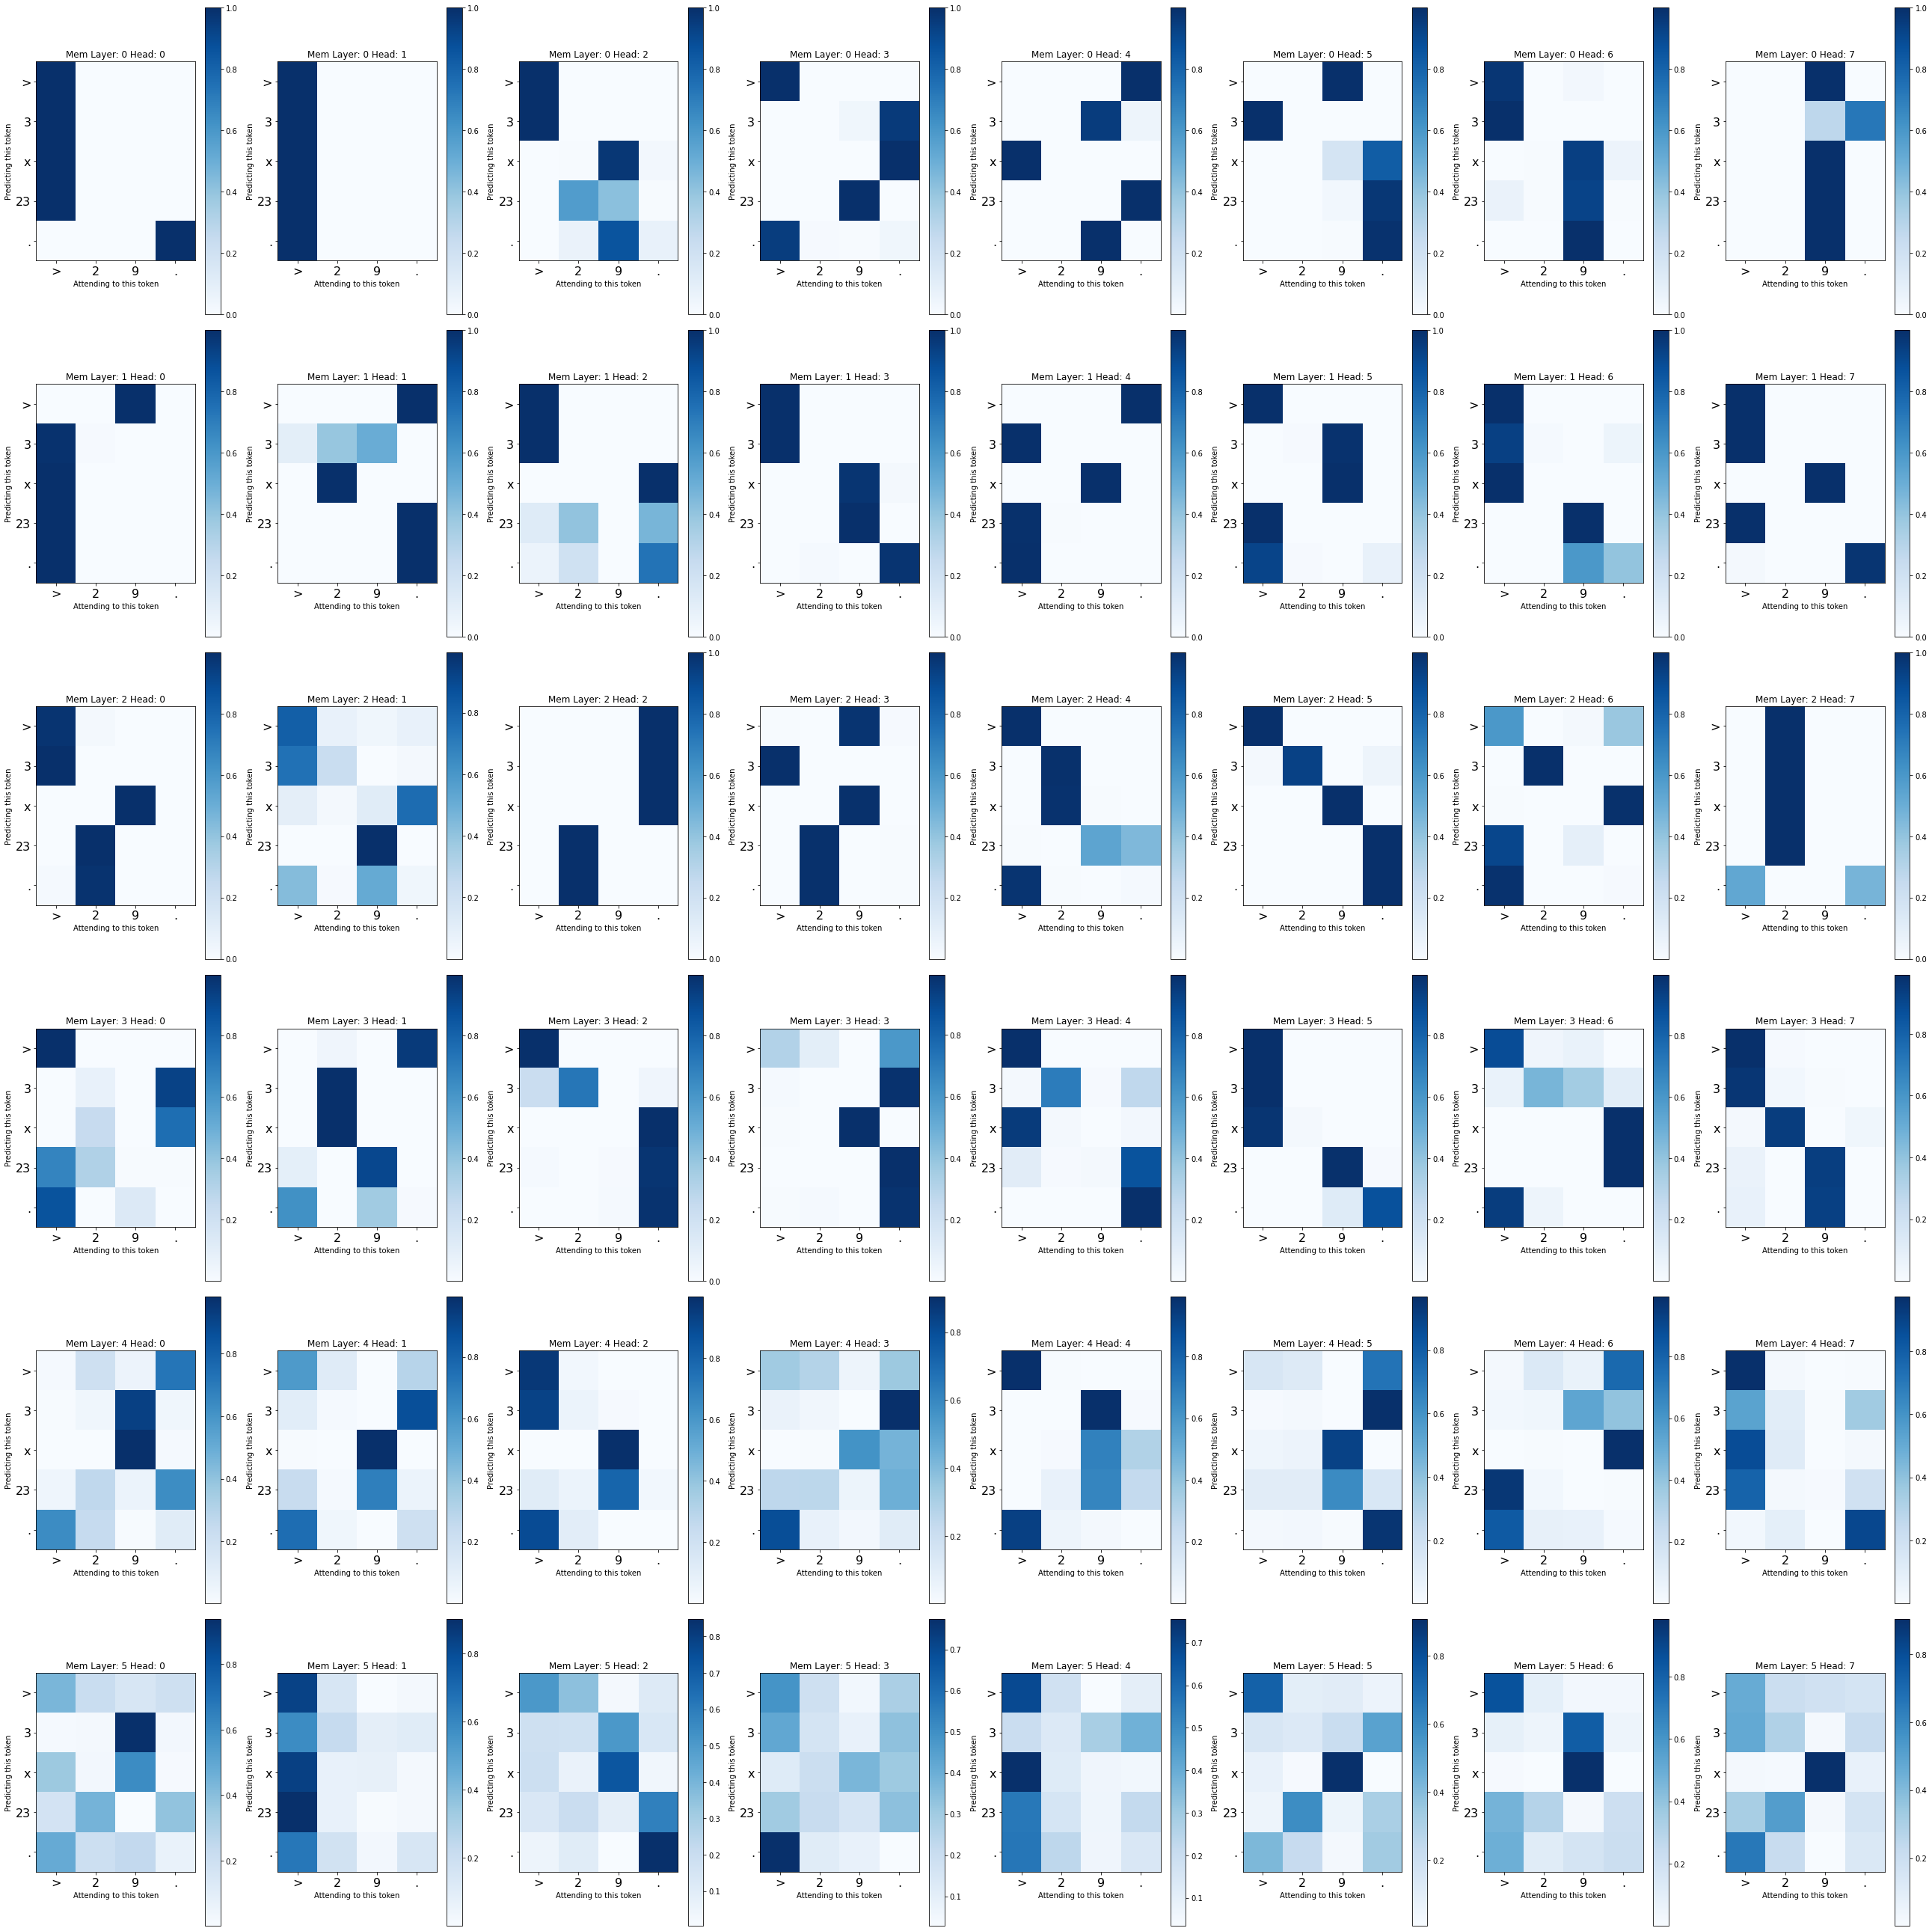

In [51]:
fig, ax = plt.subplots(mem_attn.size(0), mem_attn.size(1))

for i in range(mem_attn.size(0)):
    for j in range(mem_attn.size(1)):
        title = '%s Layer: %d Head: %d'%('Mem', i,j)
        show_attn(fig, ax[i,j], mem_attn[i][j].data.cpu().numpy(), 'mem', title)
fig.set_size_inches(36,36)
fig.tight_layout()

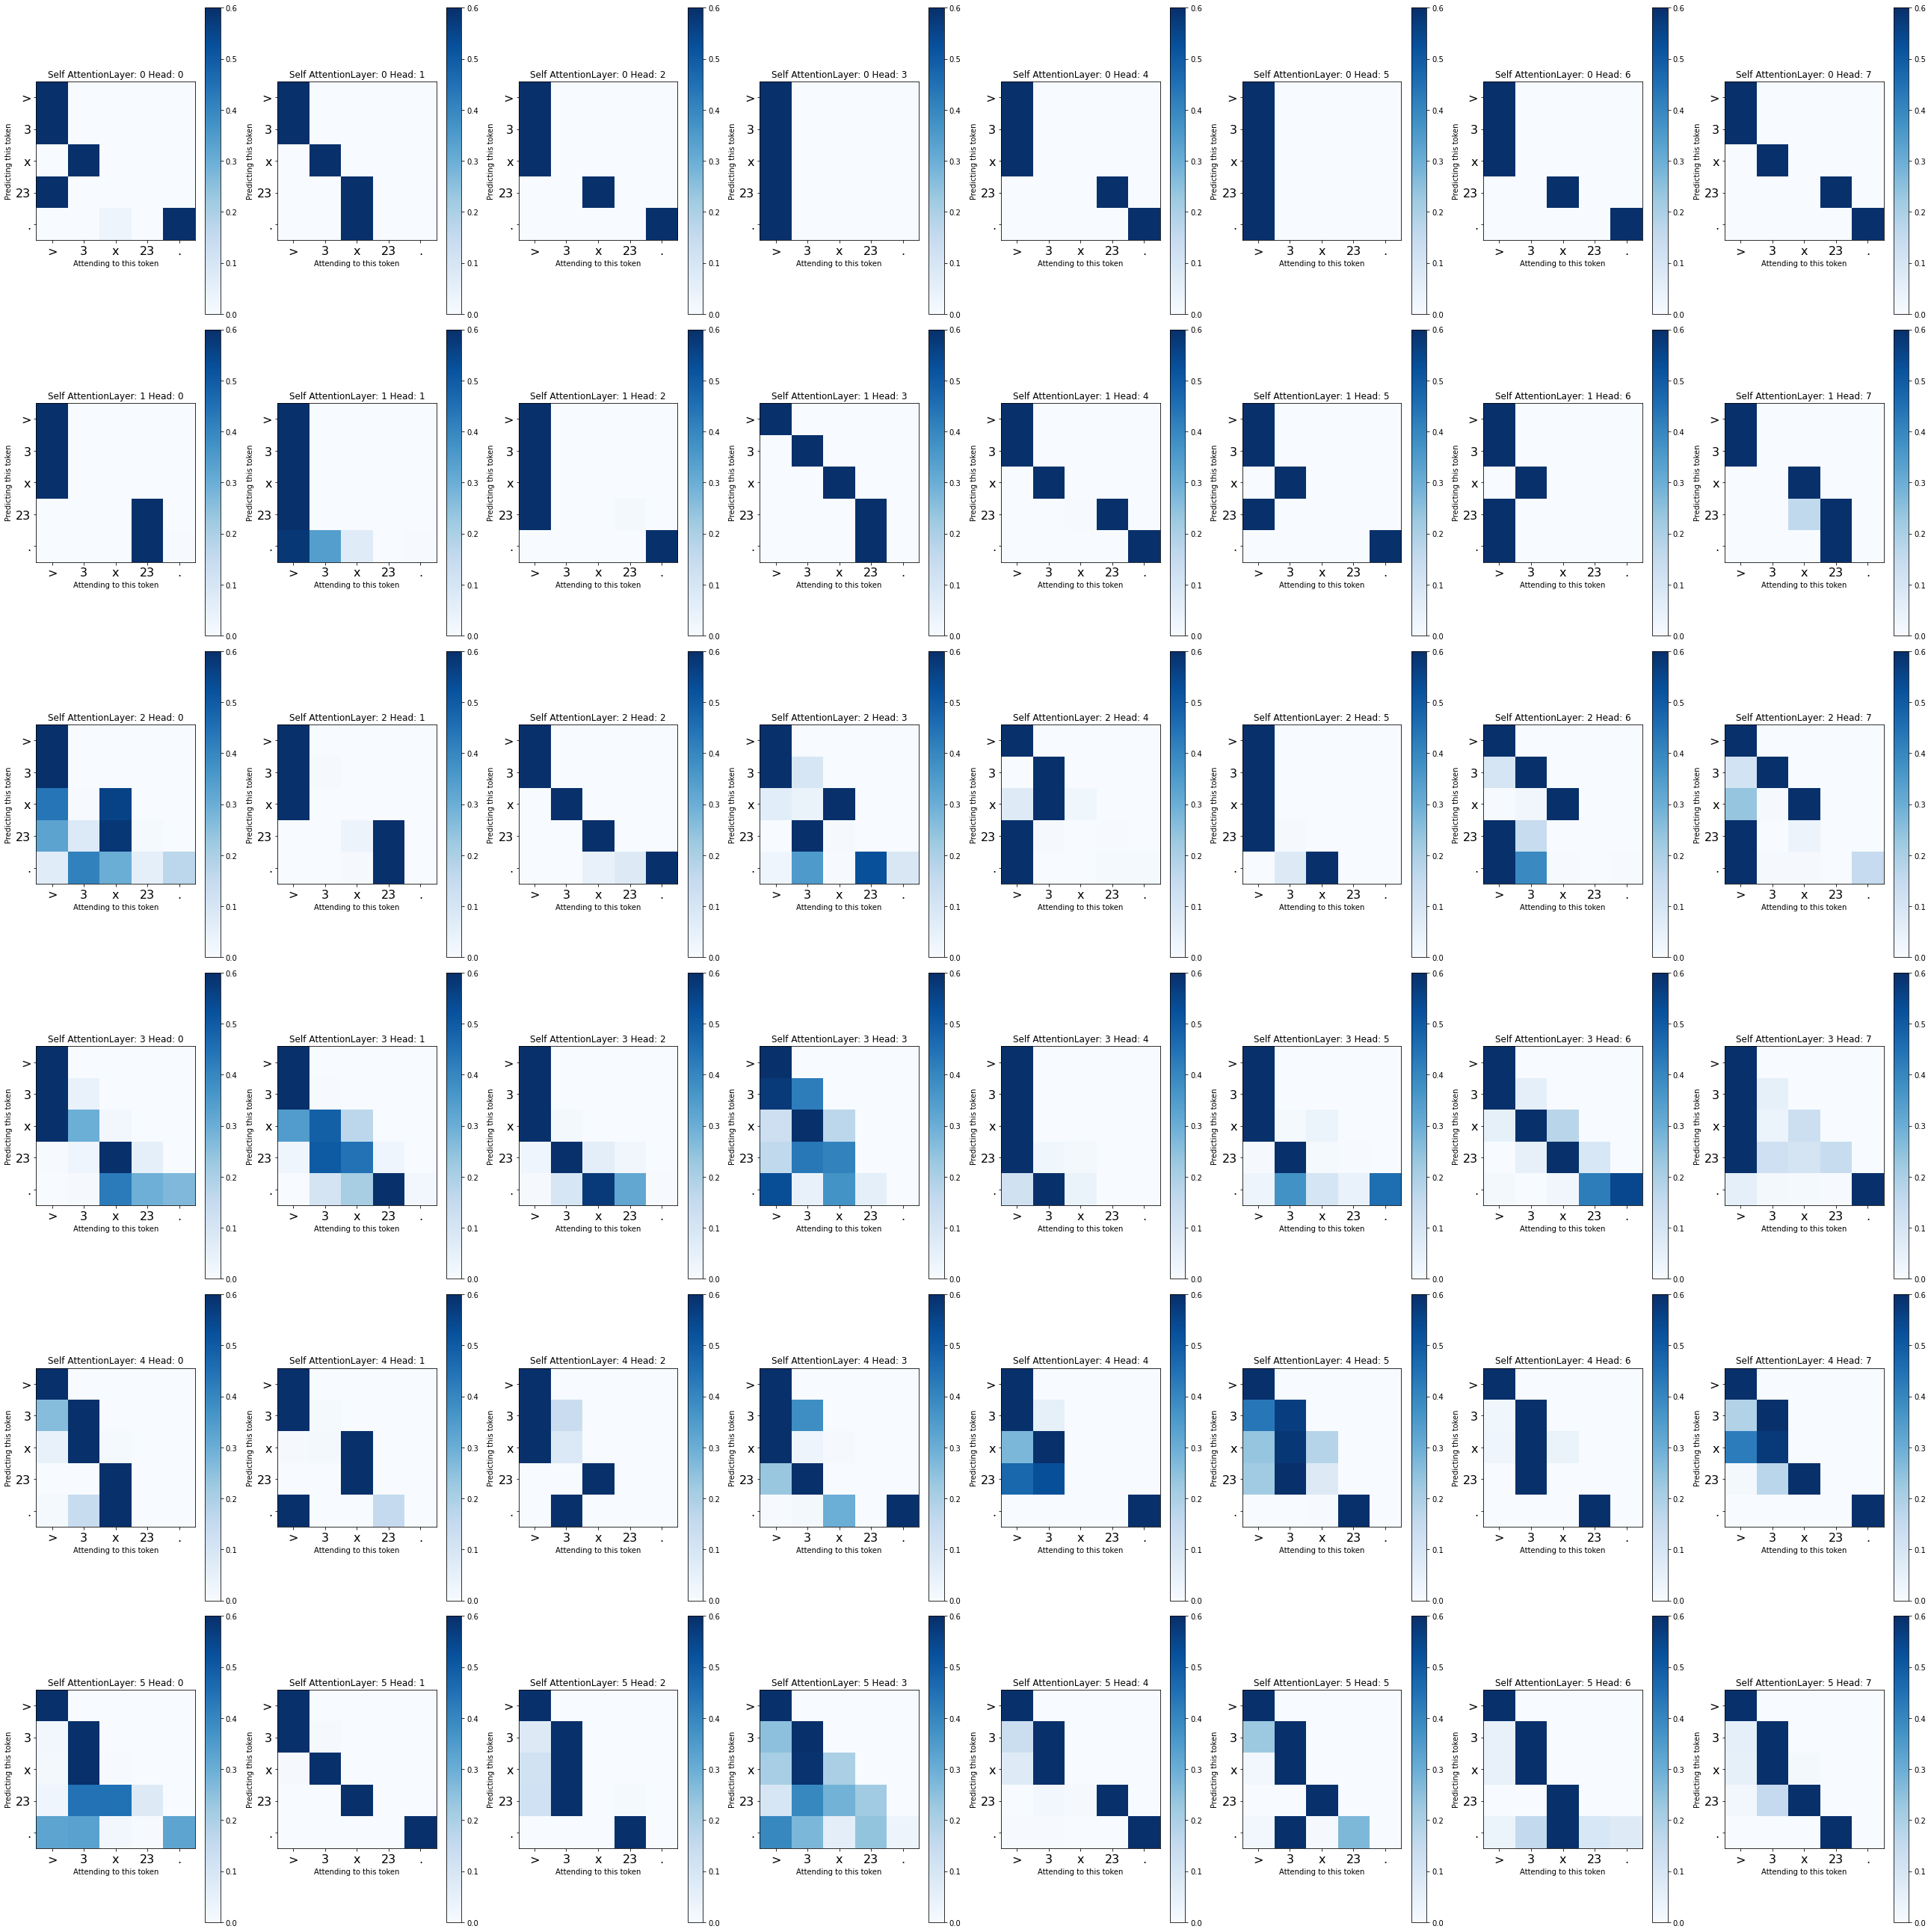

In [52]:
fig, ax = plt.subplots(self_attn.size(0), self_attn.size(1))

for i in range(self_attn.size(0)):
    for j in range(self_attn.size(1)):
        title = '%s AttentionLayer: %d Head: %d'%('Self', i,j)
        show_attn(fig, ax[i,j], np.clip(self_attn[i][j].data.cpu().numpy(), a_min=0, a_max=.6), 'self', title)
fig.set_size_inches(36,36)
fig.tight_layout()